## 规范化输入数据

In [18]:
import pandas as pd
import re

# Load your CSV
df = pd.read_csv('C:/Users/zouxu/OneDrive/Desktop/p poker/dataset/wtw1/text_total1.csv')

# Function to convert the OCR text data into a valid list of tuples
def convert_text_to_list(text):
    # Use regular expression to match the pattern and replace it
    # This assumes that the text following the coordinates does not contain any parentheses
    converted_text = re.sub(r'\(\((\d+), (\d+)\), ([^;)]+)\);?', 
                            r"((\1, \2), '\3'),", text)
    # Properly format the string as a list
    converted_text = '[' + converted_text.rstrip(',') + ']'
    return converted_text

# Apply the conversion to the 'text' column
df['text'] = df['text'].apply(convert_text_to_list)

# Now you can save this back to CSV if you need to
df.to_csv('C:/Users/zouxu/OneDrive/Desktop/p poker/dataset/wtw1/text_total3.csv', index=False)


### visualize the text coordinates 

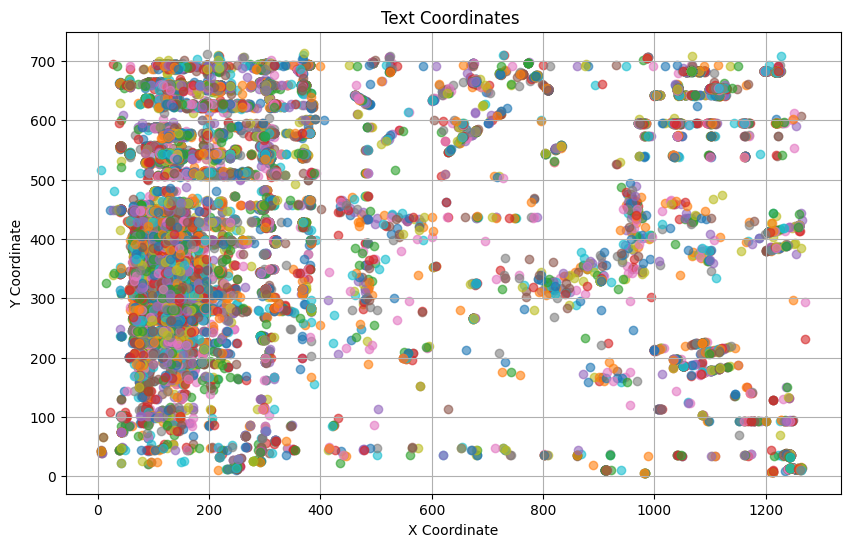

In [19]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# As I don't have access to the local CSV file system on the user's computer,
# I'll assume the file has been uploaded to the environment and proceed from there.

# Load the dataset from the uploaded CSV file
uploaded_csv_path = 'C:/Users/zouxu/OneDrive/Desktop/p poker/dataset/wtw1/text_total3.csv'  # The file path in the AI environment
df = pd.read_csv(uploaded_csv_path)

# Function to parse the text column and extract coordinates
def parse_text_column_safe(row):
    try:
        raw_data = ast.literal_eval(row)
        return [coords for coords, _ in raw_data]
    except SyntaxError:
        # Return an empty list in case of a parsing error
        return []

# Apply the revised function to the 'text' column
df['coordinates_safe'] = df['text'].apply(parse_text_column_safe)

# Collect all coordinates from the DataFrame using the updated column
all_coords_safe = [coords for sublist in df['coordinates_safe'].tolist() for coords in sublist]

# Re-plot the coordinates with the updated data
plt.figure(figsize=(10, 6))
for x, y in all_coords_safe:
    plt.scatter(x, y, alpha=0.6)
plt.title('Text Coordinates ')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

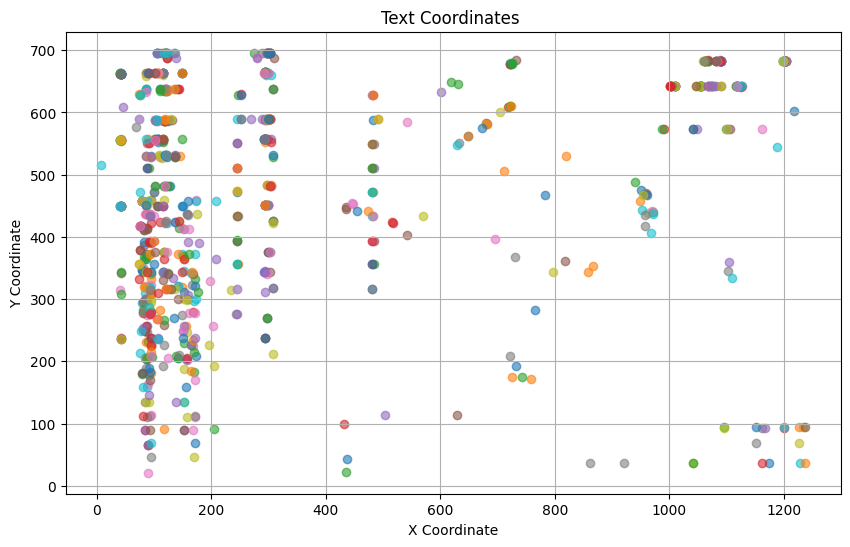

In [20]:
uploaded_csv_path = 'C:/Users/zouxu/OneDrive/Desktop/p poker/dataset/wtw1/text_data3.csv'  # The file path in the AI environment
df = pd.read_csv(uploaded_csv_path)

# Function to parse the text column and extract coordinates
def parse_text_column_safe(row):
    try:
        raw_data = ast.literal_eval(row)
        return [coords for coords, _ in raw_data]
    except SyntaxError:
        # Return an empty list in case of a parsing error
        return []

# Apply the revised function to the 'text' column
df['coordinates_safe'] = df['text'].apply(parse_text_column_safe)

# Collect all coordinates from the DataFrame using the updated column
all_coords_safe = [coords for sublist in df['coordinates_safe'].tolist() for coords in sublist]

# Re-plot the coordinates with the updated data
plt.figure(figsize=(10, 6))
for x, y in all_coords_safe:
    plt.scatter(x, y, alpha=0.6)
plt.title('Text Coordinates ')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [14]:
import pandas as pd
import matplotlib.pyplot as plt


# Since we don't have direct file access to your local drive,
# we will proceed as if the dataset has been loaded successfully into 'df'.

# Simulating dataset loading (replace with actual file loading)
df = pd.read_csv('C:/Users/zouxu/OneDrive/Desktop/p poker/dataset/wtw1/text_data3.csv')  # Placeholder for your actual data loading

# Function to parse the OCR text and coordinates
def parse_text_column(row):
    raw_data = ast.literal_eval(row)
    return [(coords, text) for coords, text in raw_data]

# Function to parse and prepare labeled data for comparison
def parse_label_column(label):
    # Simple parsing assuming labels are separated by semicolons
    # This may need to be adjusted to fit the actual format of your labels
    return [item.strip() for item in label.split(';')]

# Prepare the OCR data
ocr_data = df.apply(lambda row: parse_text_column(row['text']), axis=1)

# Prepare the labeled data
labeled_data = df['label'].apply(parse_label_column)

# Plotting
plt.figure(figsize=(20, 10))

# Plot OCR data
for index, items in ocr_data.iteritems():
    for coords, text in items:
        x, y = coords
        plt.scatter(x, y, color='blue')
        plt.text(x, y, text, fontsize=9)

# Annotate labeled data
for index, labels in labeled_data.iteritems():
    for label in labels:
        # Find the coordinates for this label in the OCR data
        for coords, text in ocr_data[index]:
            if label in text:
                x, y = coords
                plt.scatter(x, y, color='red', s=100)  # Highlight labeled text
                plt.text(x, y, label, fontsize=9, color='green')

# Final plot adjustments
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Text Coordinates from OCR Data')

# Show the plot
plt.show()

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd

# Load the dataset
df = pd.read_csv('/mnt/data/text_data2.csv')

# Check the top entries of the dataframe
print(df.head())

# Dataset class
class PokerTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_token_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        text = self.texts[index]
        labels = self.labels[index]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.long)
        }

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Process the dataset
texts = df['text'].tolist()
labels = df['label'].apply(lambda x: [int(i) for i in x.split()]).tolist() # This needs to be adjusted based on your actual label format

# Create dataset
dataset = PokerTextDataset(texts, labels, tokenizer)

# Define the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

# Train the model
trainer.train()
